# TO DO - TRY THE FOLLOWING TO SEE IF THERE IS IMPROVEMENT
1. Add Grid Search
2. Try different architectures such as:
- GRU (Gated Recurrent Unit)
- Convolutional Neural Networks (CNNs)
- Attention Mechanisms and Transformers

In [1]:
!pip install tensorflow tensorflow-metal pandas matplotlib numpy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Dataset

The dataset is downloaded from Yahoo as a csv.
For this project as of date March 1st 2024, I am choosing Berkshire Hathaway as it has gone under an stable growing trajectory and to analyse if from here there is more upside. 
Link: https://finance.yahoo.com/quote/BRK-B/history

In [2]:
import pandas as pd 
df = pd.read_csv('BRK-B.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-05-09,22.200001,24.400000,22.200001,23.200001,23.200001,4290000
1,1996-05-10,24.000000,24.200001,23.600000,24.000000,24.000000,1060000
2,1996-05-13,24.000000,24.100000,23.299999,23.900000,23.900000,700000
3,1996-05-14,24.000000,24.100000,23.100000,23.600000,23.600000,310000
4,1996-05-15,23.600000,23.700001,23.000000,23.200001,23.200001,545000
...,...,...,...,...,...,...,...
6995,2024-02-26,422.000000,430.000000,408.850006,409.140015,409.140015,7432300
6996,2024-02-27,409.209991,409.959991,401.709991,408.910004,408.910004,4609100
6997,2024-02-28,408.500000,414.670013,407.709991,412.140015,412.140015,4067400
6998,2024-02-29,413.100006,413.790009,408.380005,409.399994,409.399994,4845200


From the DataFrame, to simplify, I will just use date and market close price.

In [3]:
df = df[['Date','Close']]
df

,Date,Close
0,1996-05-09,23.200001
1,1996-05-10,24.000000
2,1996-05-13,23.900000
3,1996-05-14,23.600000
4,1996-05-15,23.200001
...,...,...
6995,2024-02-26,409.140015
6996,2024-02-27,408.910004
6997,2024-02-28,412.140015
6998,2024-02-29,409.399994


We will see what type is the Date column

In [4]:
df['Date']

0       1996-05-09
1       1996-05-10
2       1996-05-13
3       1996-05-14
4       1996-05-15
           ...    
6995    2024-02-26
6996    2024-02-27
6997    2024-02-28
6998    2024-02-29
6999    2024-03-01
Name: Date, Length: 7000, dtype: object

I want it to be a date. It can be converted to a date using datetime library.

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# Test
datetime_object = str_to_datetime('1999-01-22	')
datetime_object

# Apply to all data in the date
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/var/folders/zs/3dtlfjsx5nl25g67z3ptd61c0000gn/T/ipykernel_15499/2523567352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1996-05-09
1      1996-05-10
2      1996-05-13
3      1996-05-14
4      1996-05-15
          ...    
6995   2024-02-26
6996   2024-02-27
6997   2024-02-28
6998   2024-02-29
6999   2024-03-01
Name: Date, Length: 7000, dtype: datetime64[ns]

To get rid of the number indexing and using the date, which we now have as datetime type, df.pop can be used.

In [6]:
df.index = df.pop('Date')
df

,Close
Date,
1996-05-09,23.200001
1996-05-10,24.000000
1996-05-13,23.900000
1996-05-14,23.600000
1996-05-15,23.200001
...,...
2024-02-26,409.140015
2024-02-27,408.910004
2024-02-28,412.140015


Plot of the stock

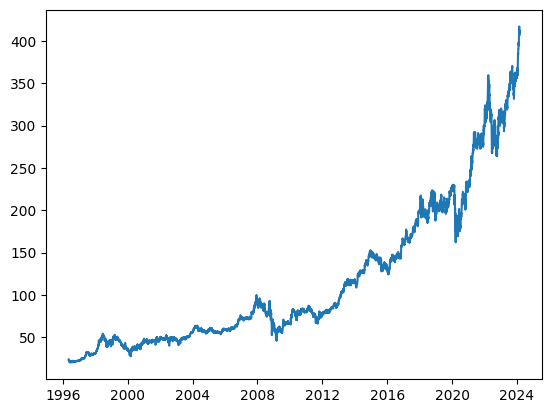

In [7]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

# Function

As this is a supervised learning problem, let's do it with the dataset by defining a function. 

## Description

This function by default takes the closing price of a certain date as well as the three previous closing prices to see an correlation.

In [8]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2016-01-01', 
                                '2024-03-01', 
                                n=2)
windowed_df

,Target Date,Target-2,Target-1,Target
0,2016-01-01,134.139999,133.259995,132.039993
1,2016-01-05,132.039993,130.750000,131.250000
2,2016-01-06,130.750000,131.250000,131.330002
3,2016-01-07,131.250000,131.330002,129.479996
4,2016-01-08,131.330002,129.479996,128.330002
...,...,...,...,...
2049,2024-02-26,415.160004,417.220001,409.140015
2050,2024-02-27,417.220001,409.140015,408.910004
2051,2024-02-28,409.140015,408.910004,412.140015
2052,2024-02-29,408.910004,412.140015,409.399994


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2054,), (2054, 2, 1), (2054,))

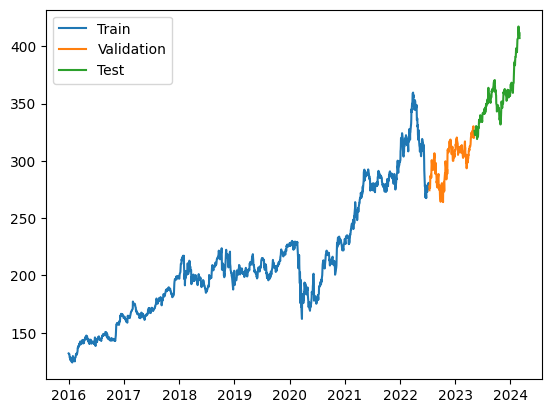

In [10]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam # legacy optimizer works better on Apple Silicon
from tensorflow.keras import layers

model = Sequential([layers.Input((2, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

2024-03-01 20:22:14.893424: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-03-01 20:22:14.893445: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-03-01 20:22:14.893449: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-03-01 20:22:14.893474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-01 20:22:14.893488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-03-01 20:22:15.615376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 2s 15ms/step - loss: 45964.6484 - mean_absolute_error: 208.2807 - val_loss: 85392.3828 - val_mean_absolute_error: 291.7985
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 37468.2930 - mean_absolute_error: 186.2952 - val_loss: 62568.0195 - val_mean_absolute_error: 249.6406
Epoch 3/100
52/52 [==============================] - 0s 10ms/step - loss: 15099.7627 - mean_absolute_error: 107.2698 - val_loss: 17960.5020 - val_mean_absolute_error: 133.0964
Epoch 4/100
52/52 [==============================] - 0s 9ms/step - loss: 2981.1514 - mean_absolute_error: 40.9643 - val_loss: 8579.5850 - val_mean_absolute_error: 91.2930
Epoch 5/100
52/52 [==============================] - 0s 9ms/step - loss: 2022.3757 - mean_absolute_error: 31.6983 - val_loss: 5126.8037 - val_mean_absolute_error: 70.0787
Epoch 6/100
52/52 [==============================] - 0s 9ms/step - loss: 617.0952 - mean_absolute_error: 12.9400 - val_loss: 1498.6134 - val_me

52/52 [==============================] - 0s 3ms/step


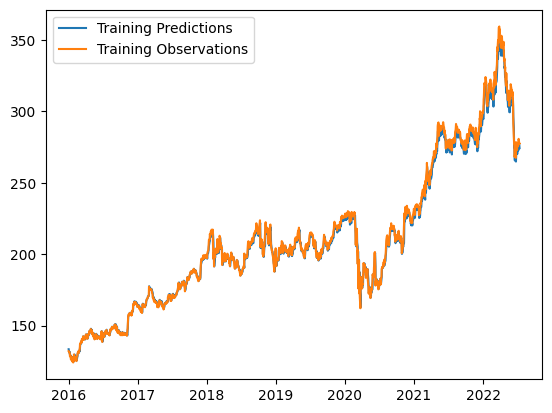

In [18]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 4ms/step


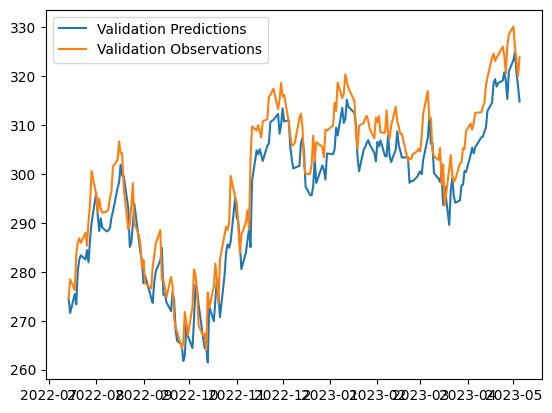

In [19]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 6ms/step


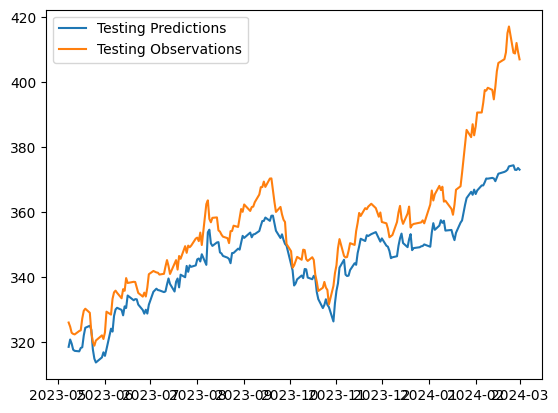

In [14]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

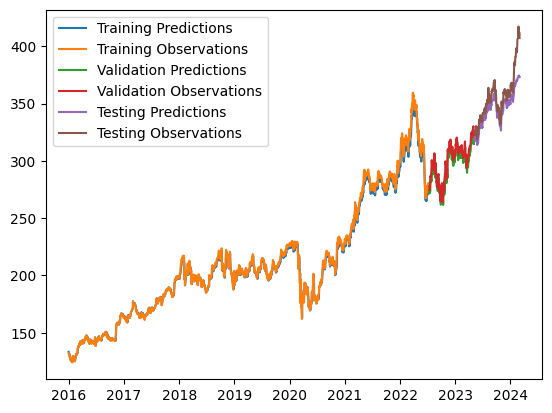

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [16]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 10ms/step


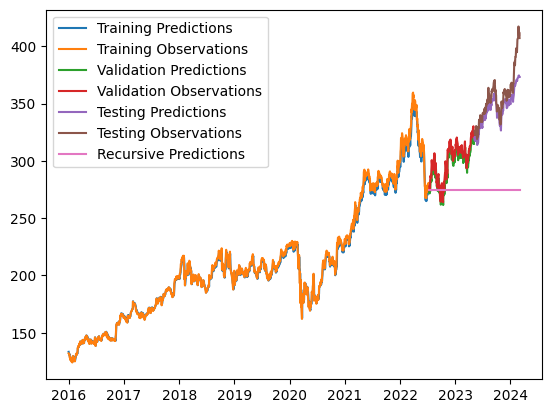

In [17]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])